The code replicates the Vision Tranfomer Paper named:

**An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale**

https://arxiv.org/abs/2010.11929

In [2]:
# Import key libraries
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
import torch.random
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import torchvision.models as models
import torchvision.datasets as datasets

from PIL import Image

import shutil
import subprocess
from pathlib import Path
import os
import sys
from google.colab import drive
import requests
import zipfile
from timeit import default_timer as timer
import time
import random

from tqdm.auto import tqdm

from typing import List, Tuple, Dict, Optional

import numpy as np

import matplotlib.pyplot as plt

import importlib

try:
  from torchinfo import summary
except:
  subprocess.run(["pip", "install", "torchinfo"],check=True)
  from torchinfo import summary

helper_function_path = "/content/Helper Functions"
if os.path.exists(helper_function_path):
  shutil.rmtree(helper_function_path)

URL = "https://github.com/anirguha/Python-2/raw/refs/heads/master/Helper%20Functions/copy_helper_functions.py"
code = requests.get(URL, timeout=30).text
exec(compile(code, URL, "exec"), {"__name__": "__main__"})

if os.path.exists("/content/Helper Functions"):
  for dirpath, dirnames, filenames in os.walk("/content/Helper Functions", topdown=True):
    sys.path.append(dirpath)
else:
  print("\u274c Error in loading Helper functions ")

import data_setup, engine, model_builder, utils, predict, icons

from helpers import download_data, set_seeds, plot_loss_curves


device = "cuda" if torch.cuda.is_available() else "cpu"


Copying folder to working directory ...
Cleaning up cloned repository ...
✅ Copy complete!
[INFO] Predicting on None


In [3]:
image_url = "https://github.com/anirguha/Python-2/raw/refs/heads/master/Machine%20Learning%20Datasets/data/pizza_steak_sushi.zip"

dest = "pizza_steak_sushi"

if os.path.exists(dest):
  print(f"\u2705 {dest} already exists...skipping")
else:
  print(f"{icons.INFO} {dest} does not exists..adding")
  image_path = download_data(image_url, dest)

ℹ️ pizza_steak_sushi does not exists..adding
ℹ️ data/pizza_steak_sushi directory exists, skipping download.


In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

# Create DataLoaders

In [5]:
# Transform the data
IMAGE_SIZE = (224,224)
transforms = v2.Compose([
    v2.Resize(IMAGE_SIZE),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [6]:
# Create dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transforms,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    device=device
)

# Visualize a random sample image from train dataloader

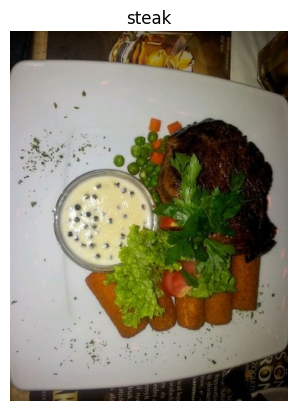

In [7]:
# Select a random image index
img_select_index = random.choice(torch.arange(len(train_dataloader.dataset.imgs))).item()

# Get the image path using the selected index
image_path_to_open = train_dataloader.dataset.imgs[img_select_index][0]

# Open the image using PIL
image_to_plot = Image.open(image_path_to_open)

# Get the class index for the selected image
class_index = train_dataloader.dataset.targets[img_select_index]

# Convert the PIL Image to a numpy array for plotting
image_to_plot_np = np.array(image_to_plot)

# Display the image
plt.imshow(image_to_plot_np)
plt.title(class_names[class_index])
plt.axis(False)
plt.show()